In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,root_mean_squared_error

In [3]:
df = pd.read_csv('Project1.csv')

In [4]:
#Drop column Order ID as its not required
df = df.drop('OrderID',axis = 1)

In [6]:
#Datetime column calculation:
df['OrderDate'] = pd.to_datetime(df['OrderDate'],dayfirst =True)

In [7]:
df['Oyear'] = df['OrderDate'].dt.year

In [8]:
df['Omonth'] = df['OrderDate'].dt.month

In [13]:
df['Oseason'] = df['OrderDate'].dt.quarter

In [13]:
df = df.drop('OrderDate', axis = 1)

In [32]:
df['Time'] = df['Oyear']* 100 + df['Omonth']

In [52]:
df['Season'] = df['Oyear']* 100 + df['Oseason']

In [53]:
df.head()

,ProductCategory,Region,Sales,Quantity,Profit,Oyear,Omonth,Oseason,Time,Season
0,0,1,474.12,5,352.32,2024,7,3,202407,202403
1,2,1,1014.01,5,126.46,2025,4,2,202504,202502
2,1,3,730.02,3,-120.90,2023,11,4,202311,202304
3,1,1,1862.52,4,255.98,2023,7,3,202307,202303
4,0,1,1880.66,2,11.38,2025,4,2,202504,202502


In [15]:
# Apply smoothing
df['Sales_Smooth'] = (
    df.groupby('ProductCategory')['Sales']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

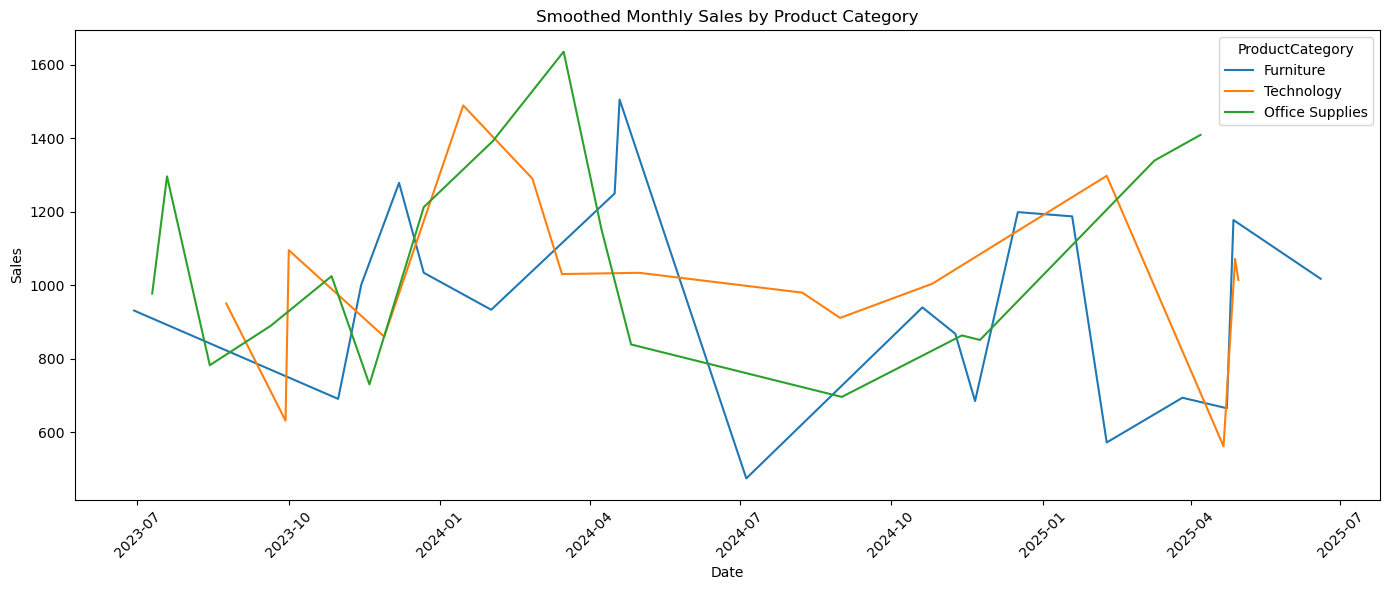

In [17]:
# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='OrderDate', y='Sales_Smooth', hue='ProductCategory')
plt.title('Smoothed Monthly Sales by Product Category')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


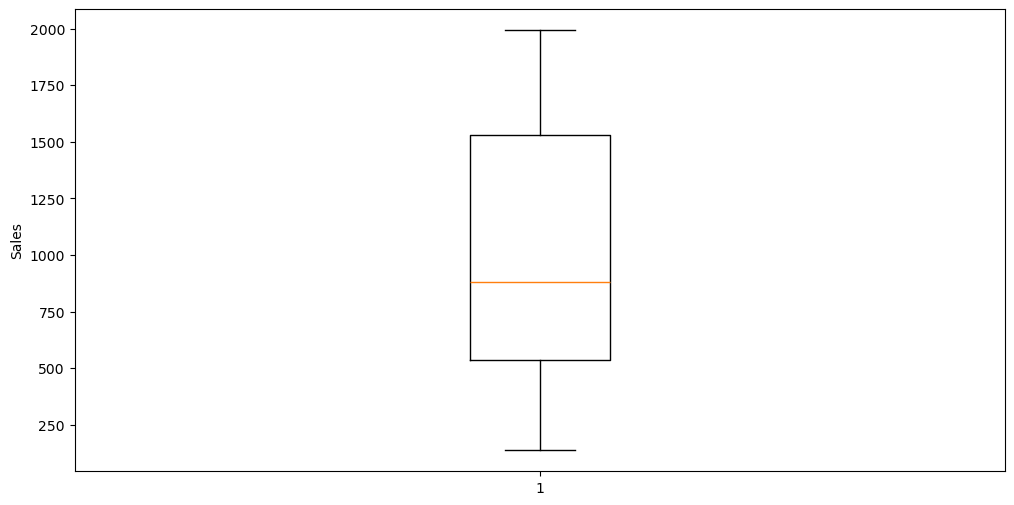

In [18]:
plt.figure(figsize =(12,6))
plt.boxplot(df['Sales'])
plt.ylabel("Sales")
plt.show()

No outliers detected as per box plot. Encoding the categorical features. 

In [19]:
df['ProductCategory'].value_counts()

ProductCategory
Furniture          19
Office Supplies    16
Technology         15
Name: count, dtype: int64

In [22]:
# Filter for "Furniture" category
furniture_sales = df[df['ProductCategory'] == 'Furniture']
furniture_series = furniture_sales.set_index('OrderDate')['Sales']

In [23]:
# Fit ARIMA model
model = ARIMA(furniture_series, order=(1,1,1))
results = model.fit()

c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting para

In [24]:
# Forecast next 6 months
forecast = results.get_forecast(steps=6)
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()

c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


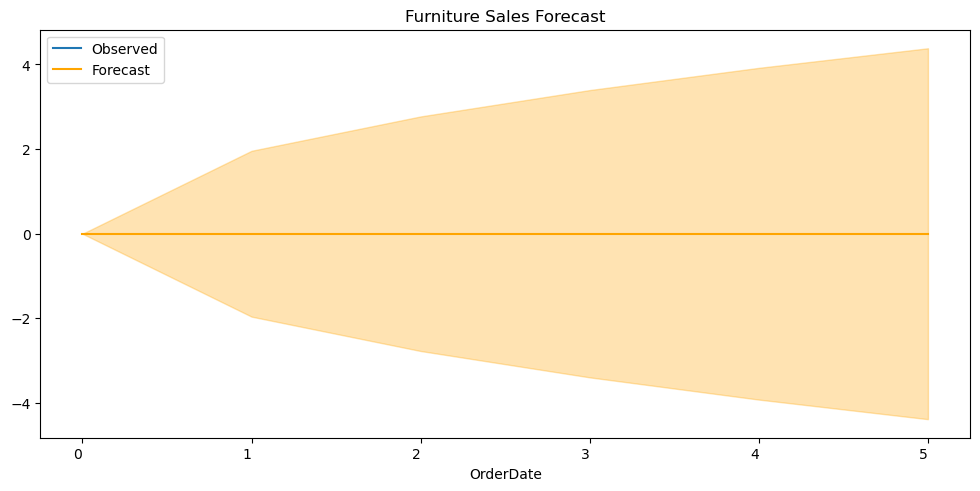

In [25]:
# Plot
plt.figure(figsize=(12,6))
furniture_series.plot(label='Observed')
predicted.plot(label='Forecast', color='orange')
plt.fill_between(predicted.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('Furniture Sales Forecast')
plt.legend()
plt.show()

In [41]:
# Create lag feature (previous month's sales)
df['Prev_Sales'] = df['Sales'].shift(1)
df.dropna(inplace=True)  # drop first row which has no previous sales




In [42]:
# Split and linear regression model
X = df[['Prev_Sales']]
y = df['Sales']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [43]:

#Predict the next month based on the latest known sales
latest_sales = df['Sales'].iloc[-1]
next_month_prediction = model.predict([[latest_sales]])

print(f"📈 Predicted sales for next month: {next_month_prediction[0]:.2f}")


📈 Predicted sales for next month: 978.50


c:\Users\nehag\anaconda3\envs\machinelearningenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


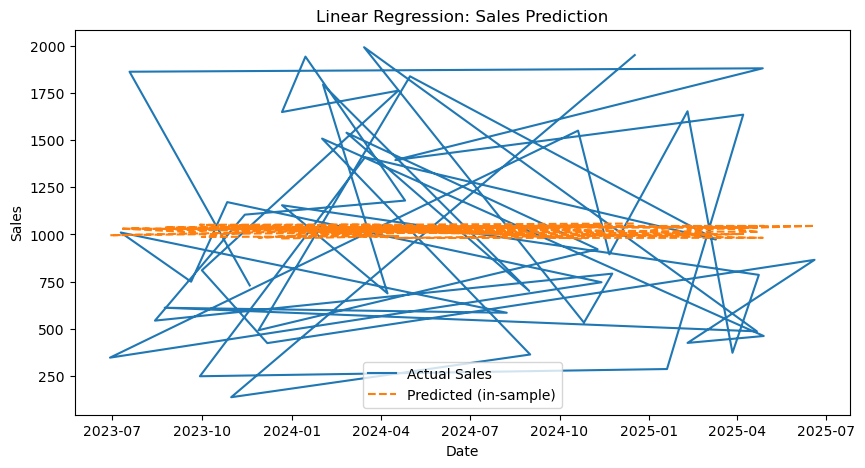

In [44]:

# Visualize
df['Predicted'] = model.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(df['OrderDate'], df['Sales'], label='Actual Sales')
plt.plot(df['OrderDate'], df['Predicted'], label='Predicted (in-sample)', linestyle='--')
plt.title("Linear Regression: Sales Prediction")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()